The Long Short-Term Memory Network (LSTM network) is a type of Recurrent Neural Network (RNN).

What is the difference between a Traditional and a Recurrent Neural Network? 

In a Traditional Neural Network, inputs and outputs are assumed to be independent of each other. However for tasks like text prediction, it would be more meaningful if the network remembered the few sentences before the word so it better understands the context. The same can be said for time series/sequential research, or predicting something cyclical in nature. 

RNNs overcome this problem as they have loops inside them, allowing them to have a memory of their previous computations. 

Backpropagation in feedforward networks moves backward from the final error through the outputs, weights and inputs of each hidden layer, assigning those weights responsibility for a portion of the error by calculating their partial derivatives – ∂E/∂w, or the relationship between their rates of change. Those derivatives are then used by our learning rule, gradient descent, to adjust the weights up or down, whichever direction decreases error.

RNNs rely on an extension of backpropagation called backpropagation through time. Time is expressed by a well-defined, ordered series of calculations linking one time step to the next, which is all backpropagation needs to work.

But even in traditional RNNs, in the gradient back-propagation training phase, the gradient signal can end up being multiplied by a large number of times (maximum the number of timesteps) by the weight matrix associated with the connections between the neurons of the recurrent hidden layer. The following two situations are therefore possible:

Vanishing Gradient Problem - if such weights are too small (ie leading eigenvalue of the weight matrix < 1), the gradient signal can become so small the learning process slows down or even stops. It can also mean long term dependencies in the data are ignored. 

Exploding Gradient Problem - if the weights are too large (ie leading eigenvalue of the weight matrix > 1), the gradient signal can cause learning to diverge.  

How does the LSTM network work differently?

LSTM networks have a cell state (instead of neurons). Gates are used to control the cell state. These gates are in turn controlled by activation units. The purpose of the gates is to conditonally remove or add information to the cell state, using weights from the activation units learned during the training.

There are three kinds of gates:

Forget Gate - decides which information to eliminate from the cell state.
This decision is activated by a sigmoid layer called the forget gate layer. This layer communicates by outputting a number between 0 and 1 depending on what the inputs are, with 0 being 'throw away everything' and 1 being 'keep everything'.

Input Gate - decides which new information from the input to update/add to the cell state.
This decision is activated by a sigmoid layer called the input gate layer. This layer selects the values to update. A tanh layer then creates a vector of new values that can be added. 

Output Gate - decides which information to output based on the cell state.
This decision is activated by a sigmoid layer which selects which parts of the memory to output. 
A tanh layer then scales the cell state values to between -1 and 1, and multiplies it with the output so to filter to the select output.

Our aim here is to train the LSTM to predict the intercept of a linear regression equation, given the beta value between the dependent and explanatory variables and these variables themselves.

First, we create an artificial cointegrated time series. 

In [498]:
def coint_path(N,delta,sigma,PO):
    X = [PO]
    Y = [PO]
    for i in range(N):
        dX = random.randn()+delta*(Y[-1] - X[-1])
        X.append(X[-1]+dX)
        dY = random.randn()+sigma*(X[-1] - Y[-1])
        Y.append(Y[-1]+dY)

    return X,Y

#create artificial cointegrated series
X,Y = coint_path(60,0.9,0.1,0)

This is what the two series look like. Please note Y in this case does not mean it is a target value.

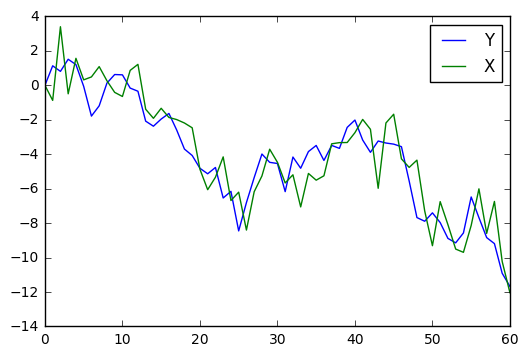

In [401]:
plt.plot(np.array(Y),label='Y')
plt.plot(np.array(X),label='X')
plt.legend()
plt.show();

We need to 'stack' the two series together into a multidimensional array. We then normalise the newly created multidimensional array using sklearn's MinMaxScaler function. This transforms the values to become between -1 and 1.

In [441]:
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1))
    data = scaler.fit_transform(data)

    return data

#format features for the model into a multidimensional array
data = prep_feature_data(X,Y)

This is what the feature data looks like now, as a multidimensional array.

In [442]:
print(data[0:3])
print(data.shape)

[[ 0.55928822  0.77041298]
 [ 0.44612865  0.94235836]
 [ 1.          0.89336033]]
(61, 2)


Now, we figure out this integer value for nb_samples. nb_samples is an integer for the next step when building lookback windows. It is how many total samples/observations less the prediction and lookback window so that we know when to stop building these windows.

In [443]:
def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples   #makes sure it can be split into lookback windows properly

    return nb_samples

#ensure it can be divided into the lookback window/batch size
nb_samples = window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW)

In [444]:
print(nb_samples)

45


Some more formatting is required now for the feature data. 
Here, we are creating lookback windows to feed into the LSTM.

np.expand_dims expands the shape of the array, by inserting a new axis that will appear at the axis position in the expanded array shape. The previous shape of each data lookback window was (number of observations,number of features) ie. With 20 being the lookback window and having 2 features, the old shape would be (20,2) and the new shape is (1, 20, 2). 

This is so that once all the separate lookback windows are concatenated together, instead of the shape being (800,2) it is (40,20,2). 
i.e 40 lookback windows of 20 lookback samples, each with 2 features.

In [445]:
def input_features(nb_samples,LOOKBACK_WINDOW):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)

    return input_mat

#format the features into the batch size
input_mat = input_features(nb_samples,LOOKBACK_WINDOW)

This is a preview of what the new input matrix looks like. Notice how the lookback window is always shifting forward one step at a time. It is not the same as simply dividing the data into groups of 20 samples.

In [446]:
print(input_mat[0:2]) #the second sample of features will become the first sample in the next window
print(input_mat.shape)

[[[ 0.55928822  0.77041298]
  [ 0.44612865  0.94235836]
  [ 1.          0.89336033]
  [ 0.49551368  1.        ]
  [ 0.76240437  0.95297434]
  [ 0.6005067   0.76148573]
  [ 0.6225156   0.49964456]
  [ 0.70007064  0.59001004]
  [ 0.59366238  0.79011148]
  [ 0.5063174   0.86559101]
  [ 0.47553949  0.86278509]
  [ 0.67173956  0.74614287]
  [ 0.71701628  0.71846731]
  [ 0.37952982  0.45497885]
  [ 0.31141229  0.41051196]]

 [[ 0.44612865  0.94235836]
  [ 1.          0.89336033]
  [ 0.49551368  1.        ]
  [ 0.76240437  0.95297434]
  [ 0.6005067   0.76148573]
  [ 0.6225156   0.49964456]
  [ 0.70007064  0.59001004]
  [ 0.59366238  0.79011148]
  [ 0.5063174   0.86559101]
  [ 0.47553949  0.86278509]
  [ 0.67173956  0.74614287]
  [ 0.71701628  0.71846731]
  [ 0.37952982  0.45497885]
  [ 0.31141229  0.41051196]
  [ 0.38672278  0.47362239]]]
(45, 15, 2)


Finally our feature data is ready to go!

Now, we create our target values. In this example, we want to train the LSTM model to predict the intercept of the linear regression line, based on the slope (beta) between the two features.

In [447]:
def target_values(input_mat):
    targets = []
    for i in range(len(input_mat)):
        X1 = input_mat[i].T[0]
        X2 = input_mat[i].T[1]
        beta = np.polyfit(X1,X2,1)[0]   #the slope is calculated from each lookback window 
        targets.append(X1[-1] - beta*X2[-1])   
    targets = np.array(targets)
    
    return targets

#format the targets into the batch size
targets = target_values(input_mat)

This is what the target data looks like. It is a one-dimensional array.

In [448]:
print(targets)
print(targets.shape)

[ 0.16383707  0.17428863  0.02369837  0.02090812  0.08470374  0.09253346
 -0.10932354 -0.2175805  -0.17839072  0.25563556 -0.14831821  0.27510788
 -0.28977952 -0.20371413 -0.26253869  0.002906   -0.08376857 -0.0607399
 -0.1961535  -0.37469998 -0.20207032 -0.28327097 -0.18187802 -0.03099024
 -0.03714489 -0.20172463 -0.15282702  0.12479884  0.13670682 -0.33619129
  0.1638934   0.24604411 -0.05675933 -0.03537451  0.13727941 -0.08861769
 -0.38428183  0.05300825  0.03815302 -0.10152241 -0.23378315 -0.32622219
  0.08748235 -0.10088805  0.17324783]
(45,)


Finally, we can create, train and predict with our LSTM model. First we will demonstrate a stateless LSTM model. In stateless mode, the LSTM will not remember the content of the previous batches (hence the lookback window). 

The Sequential model is a linear stack of layers.
We simply add layers via the .add() method.

Below are some common definitions that are necessary to know and understand to correctly utilize Keras.

Sample - one element of a dataset, e.g an image in a convolutional network, or an audio file for a speech recognition model.

BATCH_SIZE - number of samples per gradient update. A set of N samples used to train the LSTM network before updating weights. A batch results in one update to the model. So, the smaller the batch size, the faster the learning process. This is because weights are updated after each propagation, and if we used all the samples at once (a large batch size), we would have only made 1 update for the network's parameter.

Nonetheless a batch generally approximates the distribution of the input data better than a single input. So the larger the batch, the better the approximation; however, it is also true that the batch will take longer to processes and will still result in only one update. For inference (evaluate/predict), it is recommended to pick a batch size that is as large as you can afford without going out of memory.

Each batch trains network in a successive order, taking into account the updated weights coming from the appliance of the previous batch. In our case, each sample also has its own lookback window. 

e.g if you have 1000 training examples, and your batch size is 500, then it will take 2 iterations to complete 1 epoch.

e.g you have 1050 training samples and you set batch_size to 100. The network takes first 100 samples (from 1st to 100th) from the training dataset and trains network. Next, it takes second 100 samples (from 101st to 200th) and train network again. We can keep doing this procedure until we will propagate through the networks all samples. The problem usually happens with the last set of samples. In our example we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get final 50 samples and train the network. 

e.g if nb_samples=1024 and batch_size=64, it means that your model will receive blocks of 64 samples, compute each output (whatever the number of timesteps is for every sample), average the gradients and propagate it to update the parameters vector. 

batch_input_shape - if passing in features as a 3d array: (batch_size,timesteps,input_dim); if passing in features as a 2d array: (batch_size,output_dim). 

batch_input_shape defines that the sequential classification of the neural network can accept input data of the defined only batch size, restricting in that way the creation of any variable dimension vector. 

EPOCH - an arbitrary cutoff, generally defined as "one pass over the entire dataset", used to separate training into distinct phases, which is useful for logging and periodic evaluation.

HIDDEN - the number of hidden layers. 

LOOKBACK_WINDOW - the number of timesteps in a batch.

DROPOUT - a regularization method where input and recurrent connections to cell states are probabilistically excluded from activation and weight updates while training a network. This reduces overfitting to improve model performance.

OPTIMIZER - the different options can be found here https://keras.io/optimizers/

callback - you can create a custom callback by extending the base class keras.callbacks.Callback. A callback has access to its associated model through the class property self.model. Here we are recording loss history on batch end. In this example we record the total number of losses, so the length of such an array would be number of timesteps in a batch x number of epochs x 1/batch size.

Typically before modelling we would split our feature and target data into training/test sets, but because in reality we'd like to train on as much data we have available at a specific timestep, we take the walk forward approach. This involves constantly training or refitting the model and predicting one step at a time.

In [449]:
def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape
    
    model = Sequential()

    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1))       #the output is one dimensional
    
    model.compile(loss='mse',optimizer=OPTIMIZER)
    history = LossHistory()

    predictions,actuals,scores = [],[],[]
    
    assert(len(input_mat)==len(targets))   #checks each sample has a corresponding target value 
    
    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array
        
        #walk forward training, to predict the next timestep 
        #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress 
        model.fit(trainX,trainY,nb_epoch=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=0)
        prediction = model.predict(testX,batch_size=BATCH_SIZE)   
        score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)
        
        predictions.append(prediction[0][0])
        actuals.append(targets[i])
        scores.append(score)
        
    return model,history,predictions,actuals,scores

In [500]:
targets[0:3].shape

(3,)

We can evaluate the model by plotting the test score losses (these are based on mean squared error, as specified in model.compile), the training losses over each batch (this has been saved using the keras callback in model.fit), and by visually comparing the actual and predicted values against each other.

In [450]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
    print(np.mean(scores[int(len(scores)*0.75):]))   #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions
    
    plt.figure(1)
    plt.plot(history.losses)
    plt.title('Loss History')
    plt.figure(2)
    plt.plot(scores)
    plt.title('Testing Loss')
    plt.figure(3)
    plt.plot(actuals,'b-',label='actual')
    plt.plot(predictions,'g-',label='prediction')
    plt.title('Basic LSTM')
    plt.legend()
    plt.grid('on')
    plt.show()

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.00297829403902


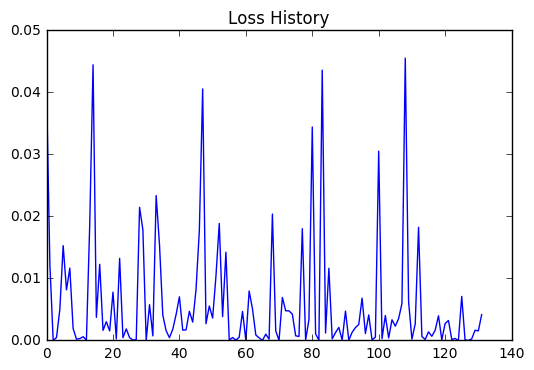

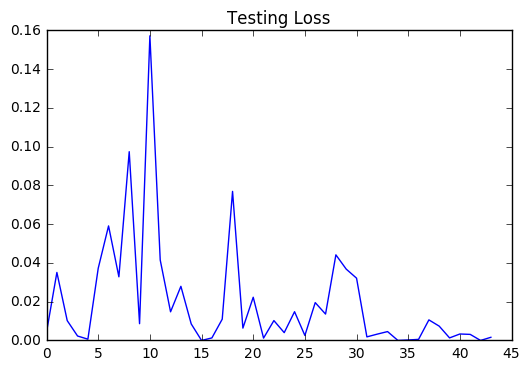

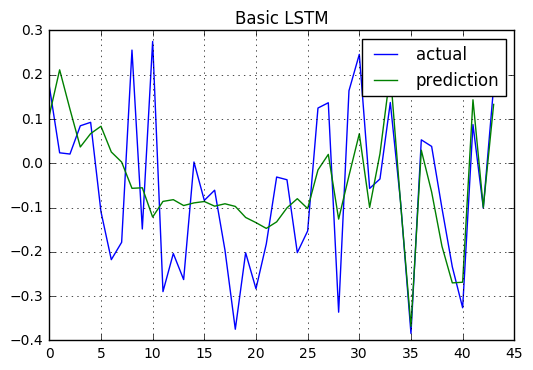

In [412]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1  #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

To better understand how the number of hidden layers, number of epochs, batch size and lookback window affects the LSTM network's performance, let's hold all else constant and evaluate the model at different values for each.

Increasing hidden layers leads to predictions catching up to actual values quicker.

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.00422957143024


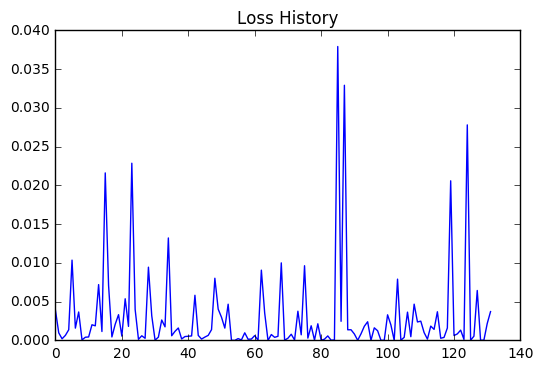

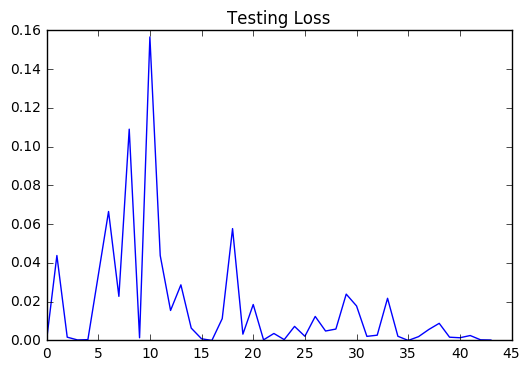

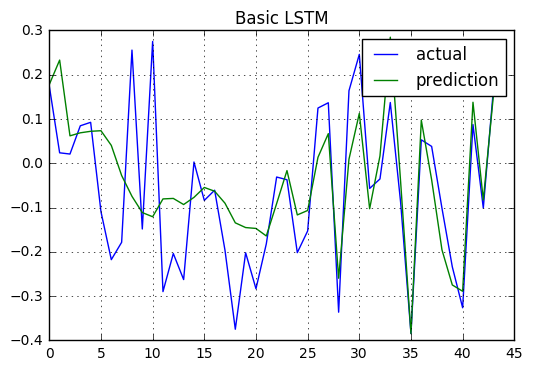

In [413]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1  
HIDDEN = 96       #96 hidden layers instead of 32
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

Setting the number of hidden layers back to 32, increasing the number of epochs also helps improve performance.

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.00599794818647


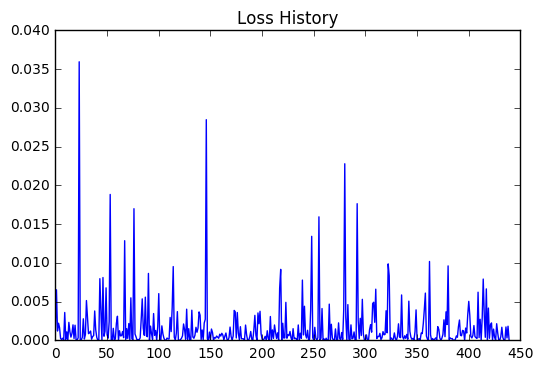

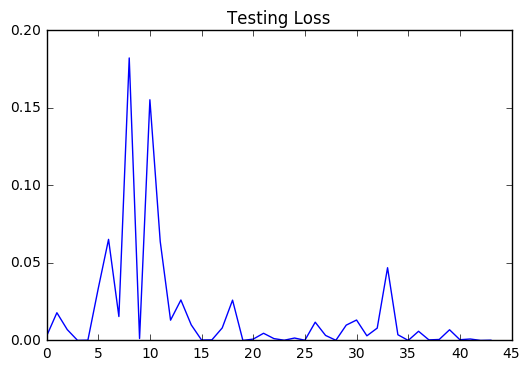

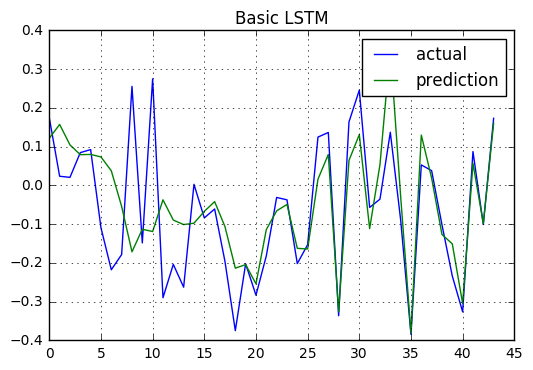

In [451]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 1  
HIDDEN = 32      
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 10    #10 epochs instead of 3 

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

Increasing batch size seems to worsen model performance.

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.031883325362


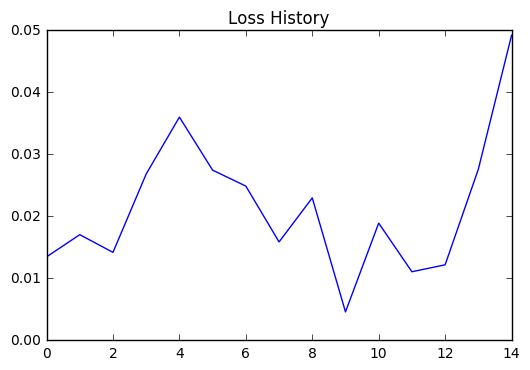

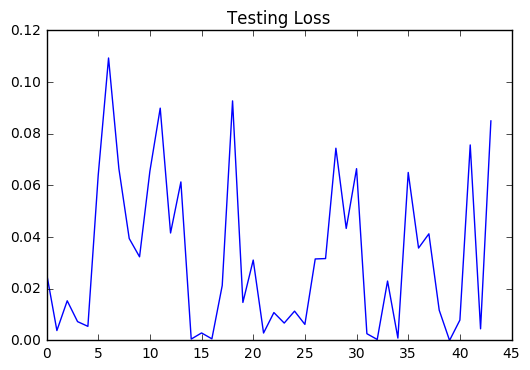

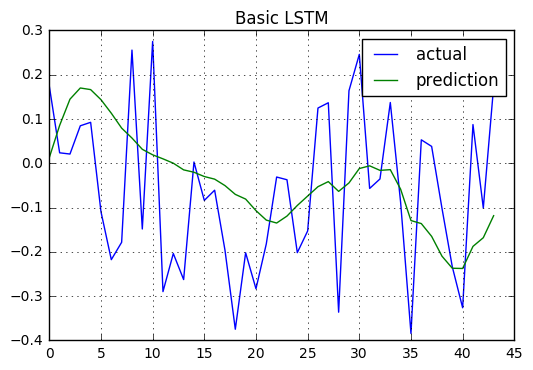

In [452]:
LOOKBACK_WINDOW = 15
PREDICT_WINDOW = 1
BATCH_SIZE = 10    #10 instead of 1  
HIDDEN = 32    
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

Decreasing lookback window also appears to worsen model performance.

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.0701490962773


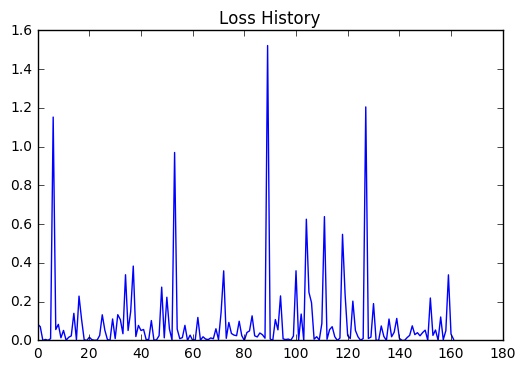

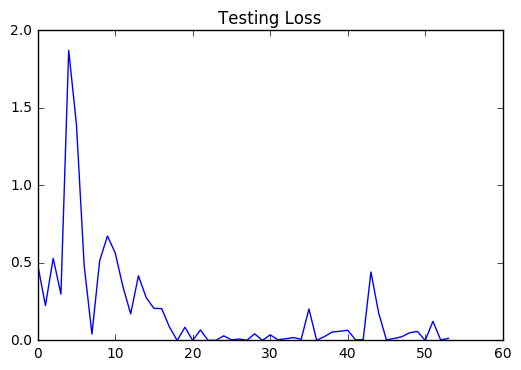

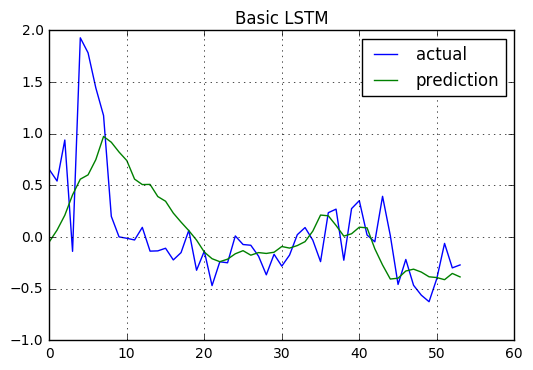

In [439]:
LOOKBACK_WINDOW = 5   #5 instead of 15 (make sure to re-run above code in data preparation as this changes the input data format)
PREDICT_WINDOW = 1
BATCH_SIZE = 1      
HIDDEN = 32    
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)

A more thorough way of observing the relationship between model performance and parameter choice can be one where we plot the score against the number of hidden layers/epochs/batch size.

In [467]:
batch_scores,batch_sizes = [],[]
for BATCH_SIZE in range(1,25):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    batch_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    batch_sizes.append(BATCH_SIZE)

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [468]:
hidden_scores,hidden_sizes = [],[]
for HIDDEN in range(15,75):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    hidden_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    hidden_sizes.append(HIDDEN)

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '
/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


In [469]:
epoch_scores,epoch_sizes = [],[]
for EPOCHS in range(1,20):
    model,history,predictions,actuals,scores = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
    epoch_scores.append(np.mean(scores[int(len(scores)*0.75):]))
    epoch_sizes.append(EPOCHS)

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


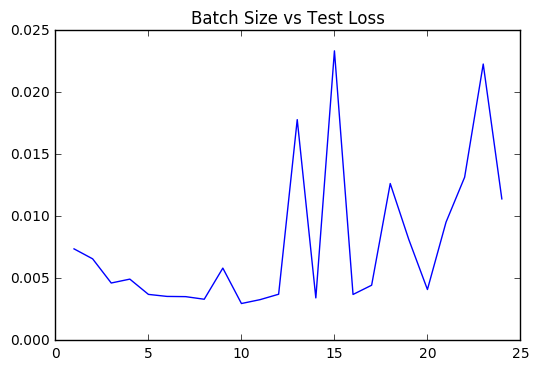

In [475]:
plt.plot(np.array(batch_sizes),np.array(batch_scores))
plt.title('Batch Size vs Test Loss')
plt.show()

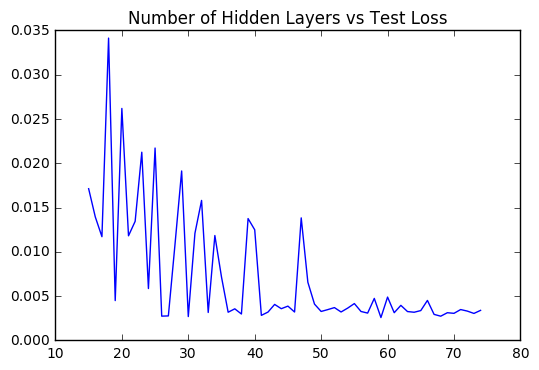

In [476]:
plt.plot(np.array(hidden_sizes),np.array(hidden_scores))
plt.title('Number of Hidden Layers vs Test Loss')
plt.show()

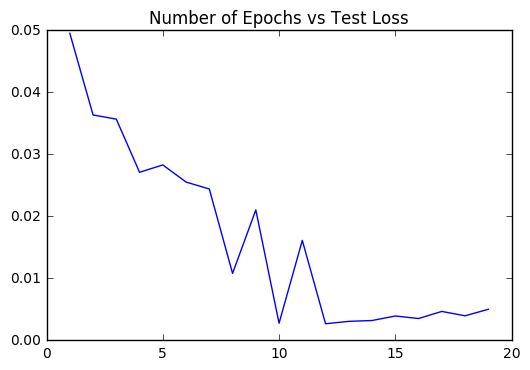

In [477]:
plt.plot(np.array(epoch_sizes),np.array(epoch_scores))
plt.title('Number of Epochs vs Test Loss')
plt.show()

For LSTM networks to be 'stateful', the states computed for the samples in one batch will be reused as initial states for the samples in the next batch. This assumes a one-to-one mapping between samples in different successive batches.

To enable statefulness: 
- specify stateful=True in the layer constructor. 
- specify a fixed batch size for your model, by passing if sequential model:  batch_input_shape=(...) to the first layer in your model. This is the expected shape of your inputs including the batch size. It should be a tuple of integers, e.g. (32, 10, 100). 
- specify shuffle=False when calling fit(). The default shuffle parameter is set to True as it assumes a basic stateless LSTM.

To reset the states of your model, call .reset_states() on either a specific layer, or on your entire model. Here we apply it at the end of the training process to ensure cell state does not carry the last sample's memory back to the start.

LSTM networks can also be multilayer or 'stacked'.

In a single layer RNN, the output is created from the input being passed through a single hidden state, so it cannot represent the structure of a sequence well.
A multi-layered RNN instead captures hierachical structure of a sequence.

For example, if modelling a test sequence, the first layer might learn differences between vowels and consonants, the second layer would build on this to learn a vowel is more likely to follow a consonant.

In [493]:
def stateful_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    features = input_mat.shape[2]
    model = Sequential()
    
    #we are stacking (4) recurrent layers by specifying return_sequences=True on any recurrent layer that feeds into another recurrent layer 
    #note that you only need to specify the input size on the first layer
    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,features),stateful=True,return_sequences=True))

    for i in range(3):
        model.add(LSTM(HIDDEN,stateful=True,return_sequences=True))
        model.add(Dropout(DROPOUT))

    #when return_sequences is False, the last output is returned as the last predicted timestep in the output sequence 
    #otherwise, the full sequence is returned 
    model.add(LSTM(HIDDEN,stateful=True))
    model.add(Dropout(DROPOUT))
    model.add(Dense(PREDICT_WINDOW))
    
    model.compile(loss='mse',optimizer=OPTIMIZER)

    history = LossHistory()

    predictions,actuals,scores = [],[],[]

    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1])
        testY = np.array([targets[i]]).reshape(1,1)
        
        for j in range(EPOCHS):   #the range is a substitute for epochs because we need to reset states at the end
            model.fit(trainX,trainY,nb_epoch=1,batch_size=BATCH_SIZE,shuffle=False,callbacks=[history],verbose=0)
            model.reset_states()

        prediction = model.predict(testX,batch_size=BATCH_SIZE)
        score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)
        
        predictions.append(prediction[0][0])
        actuals.append(targets[i])
        scores.append(score)

    return model,history,predictions,actuals,scores

/Users/Michelle/anaconda/lib/python3.5/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


0.0413093366554


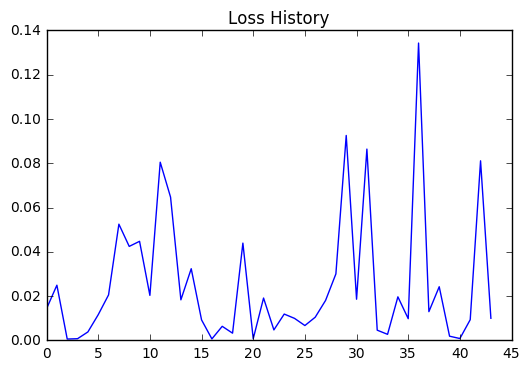

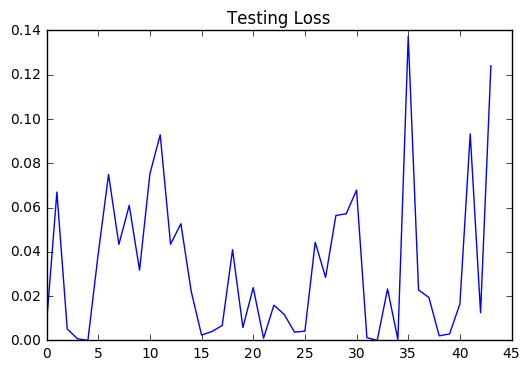

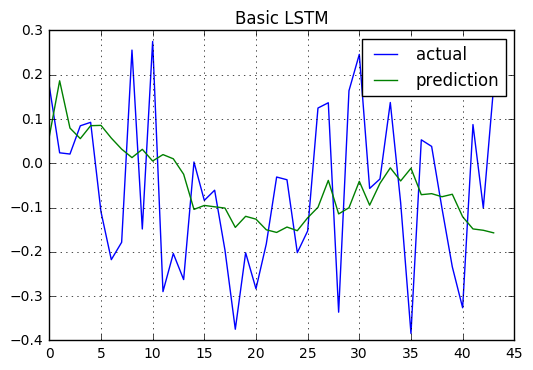

In [497]:
LOOKBACK_WINDOW = 15   
PREDICT_WINDOW = 1
BATCH_SIZE = 1    
HIDDEN = 32    
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3

model,history,predictions,actuals,scores = stateful_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets)
evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores)